### 1. Preparación del dataset

#### 1.1. Lectura del conjunto de datos

In [1]:
from scipy.io import loadmat
data=loadmat("Salinas_corrected_image.mat")['salinas_corrected']
labels=loadmat("Salinas_ground_truth.mat")['salinas_gt']
H,W,C=data.shape

#### 1.2. Reducción de la dimensionalidad

In [2]:
from sklearn.decomposition import PCA
n_components=22 # Nuestro análisis abarca 20 bandas
data=data.reshape(H*W,C)
pca=PCA(n_components=n_components,whiten=True)
data=pca.fit_transform(data)

#### 1.3. Normalización de los datos

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
standar_scaler=StandardScaler()
data=standar_scaler.fit_transform(data)
data=data.reshape(H,W,n_components);

#### 1.4. Aproximación parche a pixel

In [4]:
import numpy as np

def padWithZeros(X, margin=2):
    newX=np.zeros((X.shape[0]+2*margin,X.shape[1]+2*margin, X.shape[2]))
    x_offset=margin
    y_offset=margin 
    newX[x_offset:X.shape[0]+x_offset, y_offset:X.shape[1]+y_offset,:]=X
    return newX

def createImageCubes(X,y,windowSize=9, removeZeroLabels=True): #Regresar a 5
    margin=int((windowSize-1)/2)
    zeroPaddedX=padWithZeros(X,margin=margin)
    patchesData=np.zeros((X.shape[0]*X.shape[1],windowSize,windowSize,X.shape[2]))
    patchesLabels=np.zeros((X.shape[0]*X.shape[1]))
    patchIndex=0
    for r in range(margin,zeroPaddedX.shape[0]-margin):
        for c in range(margin,zeroPaddedX.shape[1]-margin):
            patch=zeroPaddedX[r-margin:r+margin+1,c-margin:c+margin+1]
            patchesData[patchIndex,:,:,:]=patch 
            patchesLabels[patchIndex]=y[r-margin,c-margin]
            patchIndex=patchIndex+1
    if removeZeroLabels:
        patchesData=patchesData[patchesLabels>0,:,:,:]
        patchesLabels=patchesLabels[patchesLabels>0]
        patchesLabels -=1
    from keras.utils import np_utils
    patchesLabels=np_utils.to_categorical(patchesLabels)
    return patchesData,patchesLabels 

#### 1.5. Acondicionar el conjunto de datos

In [5]:
x_train,y_train=createImageCubes(data,labels,removeZeroLabels=False)

In [6]:
n_clases=y_train.shape[1]

#### 1.6. Partir Dataset

In [7]:
# TEST 40%, TRAIN 48%, VALIDATION 12%
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,test_size=0.4,shuffle=True,random_state=0,stratify=y_train) #0.4 100% 0.9--0.79
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.2,shuffle=True,random_state=0,stratify=y_train)

### 2. Red Neuronal Convolucional

In [8]:
from tensorflow.keras.layers import Input,Conv2D,Dropout,BatchNormalization,Flatten,Dense,LayerNormalization
from tensorflow.keras.models import Model 
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
shapes=(9,9,n_components)
inputs=Input(shapes)
x=Conv2D(64,(3,3),activation="relu",padding="same")(inputs) 
x=Dropout(0.2)(x)
x=BatchNormalization()(x)
x=Conv2D(32,(3,3),activation="relu")(x)
x=Dropout(0.2)(x)
x=BatchNormalization()(x)
x=Conv2D(32,(3,3),activation="relu")(x)
x=Dropout(0.2)(x)
x=BatchNormalization()(x)
x=Flatten()(x)
x=Dense(n_clases,activation="relu")(x)
x=Dropout(0.2)(x)
x=Dense(n_clases,activation="softmax")(x)

model=Model(inputs=inputs,outputs=x)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [10]:
callback=EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)

#### 2.1. Entrenamiento

In [11]:
history=model.fit(x_train,y_train,epochs=100,batch_size=128,validation_data=(x_val,y_val),callbacks=[callback])

Epoch 1/100
417/417 [==============================] - 11s 18ms/step - loss: 0.5685 - accuracy: 0.8162 - val_loss: 0.1374 - val_accuracy: 0.9545
Epoch 2/100
417/417 [==============================] - 6s 14ms/step - loss: 0.1853 - accuracy: 0.9387 - val_loss: 0.0970 - val_accuracy: 0.9667
Epoch 3/100
417/417 [==============================] - 6s 14ms/step - loss: 0.1393 - accuracy: 0.9527 - val_loss: 0.0700 - val_accuracy: 0.9731
Epoch 4/100
417/417 [==============================] - 6s 14ms/step - loss: 0.1155 - accuracy: 0.9599 - val_loss: 0.0650 - val_accuracy: 0.9749
Epoch 5/100
417/417 [==============================] - 6s 14ms/step - loss: 0.1013 - accuracy: 0.9655 - val_loss: 0.0693 - val_accuracy: 0.9749
Epoch 6/100
417/417 [==============================] - 6s 14ms/step - loss: 0.0929 - accuracy: 0.9675 - val_loss: 0.0503 - val_accuracy: 0.9797
Epoch 7/100
417/417 [==============================] - 6s 14ms/step - loss: 0.0845 - accuracy: 0.9702 - val_loss: 0.0533 - val_accuracy

In [12]:
dic_curves_IP={}
dic_curves_IP["val_accuracy"]=history.history["val_accuracy"]
dic_curves_IP["accuracy"]=history.history["accuracy"]
dic_curves_IP["loss"]=history.history["loss"]
dic_curves_IP["val_loss"]=history.history["val_loss"]

import pickle 

with open("accu_loss_CNN2D.pkl","wb") as f:
    pickle.dump(dic_curves_IP,f)

#### 3. Evaluación

#### 3.1. Evaluacion Test

In [13]:
evaluacion_test=model.evaluate(x_test,y_test)

1389/1389 [==============================] - 8s 5ms/step - loss: 0.0343 - accuracy: 0.9859


#### 3.2. Classification Report

In [14]:
y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
from sklearn.metrics import classification_report
clases_dataset_SA=["Unlabeled","Brocoli_green_weeds_1","Brocoli_green_weeds_2","Fallow","Fallow_rough_plow","Fallow_smooth","Stubble","Celery","Grapes_untrained","Soil_vinyard_develop","Corn_senesced_green_weeds","Lettuce_romaine_4wk","Lettuce_romaine_5wk","Lettuce_romaine_6wk","Lettuce_romaine_7wk","Vinyard_untrained","Vinyard_vertical_trellis"]
target_names=clases_dataset_SA
classification=classification_report(np.argmax(y_test,axis=1),y_pred,target_names=target_names)
print(classification)

1389/1389 [==============================] - 4s 3ms/step
                           precision    recall  f1-score   support

                Unlabeled       0.99      0.98      0.99     22790
    Brocoli_green_weeds_1       0.99      0.99      0.99       804
    Brocoli_green_weeds_2       0.98      1.00      0.99      1490
                   Fallow       0.97      0.99      0.98       790
        Fallow_rough_plow       0.90      0.98      0.93       558
            Fallow_smooth       0.94      0.99      0.96      1071
                  Stubble       0.97      1.00      0.98      1584
                   Celery       0.99      0.99      0.99      1432
         Grapes_untrained       0.99      1.00      0.99      4509
     Soil_vinyard_develop       0.98      1.00      0.99      2481
Corn_senesced_green_weeds       0.98      1.00      0.99      1311
      Lettuce_romaine_4wk       0.94      0.98      0.96       427
      Lettuce_romaine_5wk       0.97      1.00      0.99       771
    

#### 3.3. Cohen Kappa

In [15]:
from sklearn.metrics import cohen_kappa_score
a=y_pred
b=np.argmax(y_test,axis=1)
cks=cohen_kappa_score(a,b)
cks

np.save("cohen_kappa_score_cnn2d",cks)

In [16]:
import numpy as np 
np.load("cohen_kappa_score_cnn2d.npy")

array(0.98028593)

In [17]:
import pandas as pd 

pd_reporte_clasificacion=pd.DataFrame(classification_report(np.argmax(y_test,axis=1),y_pred,target_names=target_names,output_dict=True)).transpose()
pd_reporte_clasificacion.to_csv("reporte_clasificacion_cnn2d.csv")

In [18]:
y_pred,_=createImageCubes(data,labels,removeZeroLabels=False)
y_pred=model.predict(y_pred,batch_size=128)
y_pred=np.argmax(y_pred,axis=1)
y_pred=y_pred.reshape(H,W)

868/868 [==============================] - 3s 4ms/step


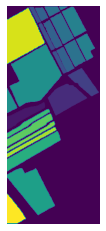

In [19]:
import matplotlib.pyplot as plt 
plt.imshow(y_pred)
plt.axis("off");

In [20]:
np.save("y_pred_cnn2d",y_pred)

(-0.5, 216.5, 511.5, -0.5)

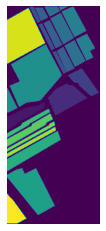

In [21]:
plt.imshow(labels)
plt.axis("off")

In [22]:
from sklearn.metrics import accuracy_score
a=y_pred.reshape(H*W)
b=labels.reshape(H*W)
cohen_kappa_score(a,b)

0.9842672923687382

In [23]:
accuracy_score(a,b)

0.9887312788018433

In [24]:
from keras.metrics import MeanIoU 
n_classes=17
IOU_mean=MeanIoU(num_classes=n_classes)
IOU_mean.update_state(y_pred,labels)
print("Mean IoU",IOU_mean.result().numpy())
np.save("IoU_cnn2d",IOU_mean.result().numpy())

Mean IoU 0.9666448


In [25]:
# IoU por clase.
from keras.metrics import IoU
clases=["Unlabeled","Brocoli_green_weeds_1","Brocoli_green_weeds_2","Fallow","Fallow_rough_plow","Fallow_smooth","Stubble","Celery","Grapes_untrained","Soil_vinyard_develop","Corn_senesced_green_weeds","Lettuce_romaine_4wk","Lettuce_romaine_5wk","Lettuce_romaine_6wk","Lettuce_romaine_7wk","Vinyard_untrained","Vinyard_vertical_trellis"]
IoU_class_report=[]
for i in range(17):
    IoU_class=IoU(num_classes=17,target_class_ids=[i])
    IoU_class.update_state(y_pred,labels)
    IoU_class_report.append(IoU_class.result().numpy())
    print(clases[i],":", IoU_class.result().numpy())

Unlabeled : 0.9781841
Brocoli_green_weeds_1 : 0.98225725
Brocoli_green_weeds_2 : 0.9846642
Fallow : 0.9703117
Fallow_rough_plow : 0.9052008
Fallow_smooth : 0.9413013
Stubble : 0.9716609
Celery : 0.98090756
Grapes_untrained : 0.9920565
Soil_vinyard_develop : 0.98489904
Corn_senesced_green_weeds : 0.9763968
Lettuce_romaine_4wk : 0.93386245
Lettuce_romaine_5wk : 0.96779066
Lettuce_romaine_6wk : 0.9388601
Lettuce_romaine_7wk : 0.9482605
Vinyard_untrained : 0.9917932
Vinyard_vertical_trellis : 0.98455596


In [26]:
np.save("reporte_IoU_cnn2d",IoU_class_report)

In [27]:
from keras.metrics import IoU
clases=["Unlabeled","Brocoli_green_weeds_1","Brocoli_green_weeds_2","Fallow","Fallow_rough_plow","Fallow_smooth","Stubble","Celery","Grapes_untrained","Soil_vinyard_develop","Corn_senesced_green_weeds","Lettuce_romaine_4wk","Lettuce_romaine_5wk","Lettuce_romaine_6wk","Lettuce_romaine_7wk","Vinyard_untrained","Vinyard_vertical_trellis"]
IoU_class_report=[]
for i in range(n_clases):
    IoU_class=IoU(num_classes=n_clases,target_class_ids=[i])
    IoU_class.update_state(y_pred,labels)
    IoU_class_report.append(IoU_class.result().numpy())
    print(IoU_class.result().numpy())

0.9781841
0.98225725
0.9846642
0.9703117
0.9052008
0.9413013
0.9716609
0.98090756
0.9920565
0.98489904
0.9763968
0.93386245
0.96779066
0.9388601
0.9482605
0.9917932
0.98455596
